#### GRUPO: aasj2; abl2; gbgv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('glass.csv', index_col='id')

In [3]:
X = df.loc[:, [col for col in df if col != 'Type']]
y = df['Type']

# Análise Exploratória

In [4]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Medidas de tendência central

In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


### Correlação

Podemos perceber através do mapa de calor abaixo que existe uma alta correlação entre o **índice de refração** e a quantidade de **calcio** presente, bem como uma correlação negativa entre **índice de refração** e **silício**, e entre **magnésio** e outros elementos como **alumínio**, **cálcio** e **bário**. O mais interessante porém é a alta correlação negativa entre o atributo de classe **Type** e o **magnésio**

<AxesSubplot:>

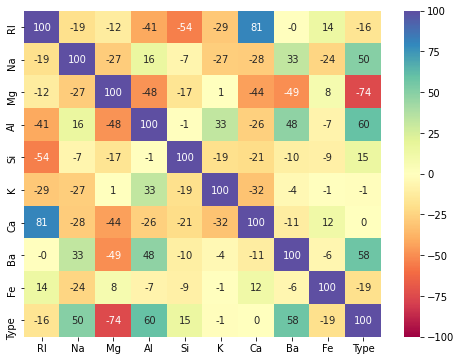

In [6]:
plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr() * 100, annot=True, fmt=".0f", vmin=-100, vmax=100, cmap='Spectral')

# Pre-processamento

## Detecção de outliers

Pelo box plot abaixo é possível perceber a presença de vários outliers em cada atributo isoladamente

<AxesSubplot:>

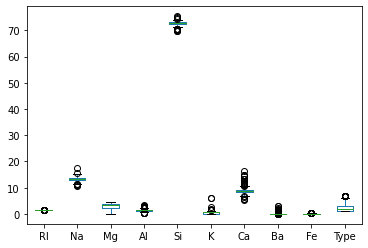

In [7]:
df.plot.box()

Na sequência é realizado o teste de shapiro para verificar se os atributos seguem uma curva normal e decidir qual algoritmo de detecção de outliers multivariado será utilizado


In [8]:
significance = .01
for col in X.columns:
    print(f'{col} is Gaussian: {stats.shapiro(df[col]).pvalue > significance}')

RI is Gaussian: False
Na is Gaussian: False
Mg is Gaussian: False
Al is Gaussian: False
Si is Gaussian: False
K is Gaussian: False
Ca is Gaussian: False
Ba is Gaussian: False
Fe is Gaussian: False


Como nenhum atributo se comportou como uma gaussiana, será utilizado o Isolation Forest, que é um teste não paramétrico.

In [9]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(random_state=0)

<AxesSubplot:>

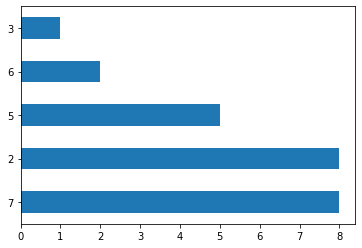

In [10]:
outliers = df[iforest.fit_predict(X) == -1]
outliers['Type'].value_counts().plot.barh()

<AxesSubplot:>

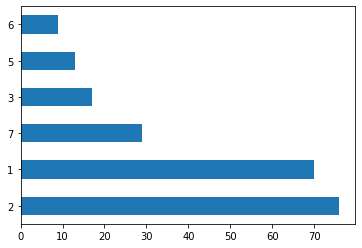

In [11]:
df['Type'].value_counts().plot.barh()

<AxesSubplot:>

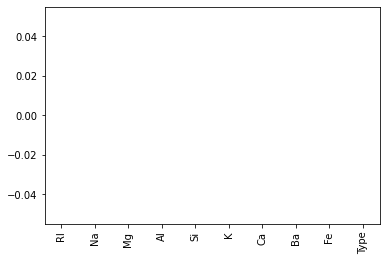

In [12]:
df.isna().sum().plot.bar()

Como a quantidade de outliers foi baixa e de duas classes predominantemente (2 e 7), optamos por não retirar nenhum dado; e como também não há instância com dados ausentes não precisamos imputar.

# SVM

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score

In [14]:
splits, repeats = 5, 10
rkf = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state=0)

In [15]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
polys = [i+1 for i in range(len(X.columns), len(X.columns) + 30)]

In [16]:
%%time

f1scores = dict()
for kernel in kernels:
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if kernel == 'poly':
            for d in polys:
                clf = SVC(kernel=kernel, degree=d)
                clf.fit(X_train, y_train)
                f1scores[f'{kernel}_{d}'] = f1scores.get(f'{kernel}_{d}', 0) + f1_score(y_test, clf.predict(X_test), average='micro')
        else:
            clf = SVC(kernel=kernel)
            clf.fit(X_train, y_train)
            f1scores[kernel] = f1scores.get(kernel, 0) + f1_score(y_test, clf.predict(X_test), average='micro')
            
for k in f1scores:
    f1scores[k] /= splits * repeats
    if k == 'poly':
        f1scores[k] /= len(polys)

CPU times: user 25.8 s, sys: 0 ns, total: 25.8 s
Wall time: 25.8 s


<AxesSubplot:>

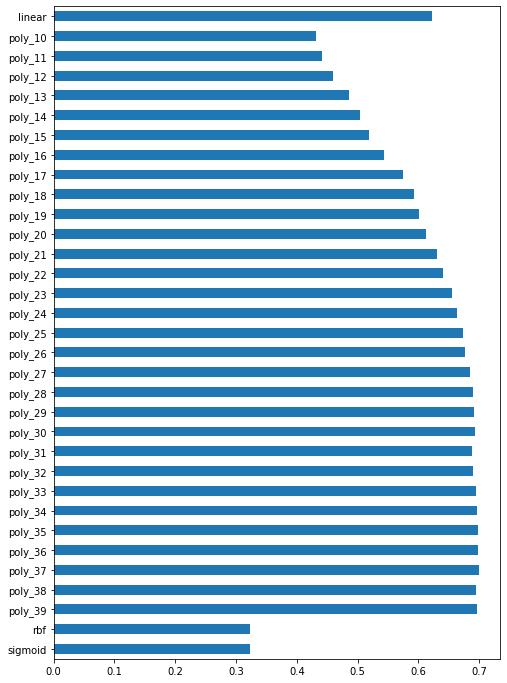

In [17]:
s = pd.Series(f1scores).sort_index(ascending=False)
s.plot.barh(figsize=(8, 12))

In [18]:
s

sigmoid    0.322525
rbf        0.322525
poly_39    0.696257
poly_38    0.694396
poly_37    0.699070
poly_36    0.697685
poly_35    0.697231
poly_34    0.696312
poly_33    0.694441
poly_32    0.689280
poly_31    0.687409
poly_30    0.692536
poly_29    0.691141
poly_28    0.689767
poly_27    0.684607
poly_26    0.677154
poly_25    0.672470
poly_24    0.663134
poly_23    0.655670
poly_22    0.640244
poly_21    0.630476
poly_20    0.612691
poly_19    0.600587
poly_18    0.592115
poly_17    0.575238
poly_16    0.543876
poly_15    0.519037
poly_14    0.504109
poly_13    0.485338
poly_12    0.460155
poly_11    0.440664
poly_10    0.431285
linear     0.622027
dtype: float64

É possível concluir de acordo com os F-scores acima que os kernels linear e polinomial obtiveram um melhor resultado comparado com os demais. Apesar de o linear ser o kernel mais simples, isso pode se dar pelo fato de a classe ter uma alta correlação negativa com um atributo especificamente, entre outras correlações relevantes com certos atributos, o que torna essa divisão no hiperplano um pouco melhor. É possível notar também a melhoria do desempenho do kernel polinomial a medida que é aumentado o grau até a casa dos 30 